In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# Fetch data

In [2]:
from urllib.request import urlretrieve
for i in range(1,7):
    print('downloading.. {}'.format(i))
    filename, headers = urlretrieve('http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron{}.tar.gz'.format(i), './enron{}.tar.gz'.format(i))

downloading.. 1
downloading.. 2
downloading.. 3
downloading.. 4
downloading.. 5
downloading.. 6


In [12]:
import tarfile
for i in range(1,7):
    print('Uncompressing... {}'.format(i))
    filename = tarfile.open('enron{}.tar.gz'.format(i))
    filename.extractall('.'.format(i))
    filename.close()

Uncompressing... 1
Uncompressing... 2
Uncompressing... 3
Uncompressing... 4
Uncompressing... 5
Uncompressing... 6


In [18]:
emails,labels=[],[]
for i in range(1,7):
    spam_path='enron{}/spam/'.format(i)
    for filename in glob.glob(os.path.join(spam_path,'*.txt')):
        with open(filename,'r',encoding='ISO-8859-1') as infile:
            emails.append(infile.read())
            labels.append(1)
    ham_path='enron{}/ham/'.format(i)
    for filename in glob.glob(os.path.join(ham_path,'*.txt')):
        with open(filename,'r',encoding='ISO-8859-1') as infile:
            emails.append(infile.read())
            labels.append(0)
print('Nonspam (lable=0) : spam (label=1) = {:.2f}%:{:.2f}%'.format(100*(1-sum(labels)/len(labels)),100*(sum(labels)/len(labels))))

# Preprocessing

In [ ]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
all_name=set(names.words())
lemmatizer=WordNetLemmatizer()

In [ ]:
def clean_text(docs):
    '''remove words composed of names, non letter characters. Then lemmatize it.
    
    Parameters
    ----------
    docs: list
        list of original emails
        
    Returns
    -------
    docs_cleaned: list
        list of cleaned emails
    '''
    docs_cleaned=[]
    for doc in docs:
        doc_cleaned= ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word not in all_name and word.isalpha())
        docs_cleaned.append(doc_cleaned)
    return docs_cleaned

In [ ]:
emails_clean=clean_text(emails)

In [ ]:
len(emails_clean)

5857

# Construct Bayes model from scratch

In [11]:
class Bayes:
    def __init__(self,X_train,y_train,X_test=None,y_test=None):
        '''Detect spam emails using naive Bayes. The texts of emails are treated uisng bag of words (BOW) model.

        Parameters
        -----------
        X_train: list
            Text for training data.
        y_train: list
            Label for training data.
        X_test: list, optional
            Text for test data.
        y_test: list, optional
            Label for test data.
        '''
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
        self.label_to_text={0:'NonSpam',1:'Spam'}
        
    def countvectorizer(self,**kwargs):
        '''Vectorize texts by calling `CountVectorizer` from `sklearn`. The converted matrices for training and test data are `self.term_docs_train` and `self.term_docs_test`. The dimension is num_samples by num_features.

        Parameters
        -----------
        **kwargs: dict, optional
            Same parameters for CounterVectorizer
            Default:
            stop_words='english'
            max_features=1000
            max_df=0.5
            min_df=2
        '''
        kwargs['stop_words']=kwargs.get('stop_words','english')
        kwargs['max_features']=kwargs.get('max_features',1000)
        kwargs['max_df']=kwargs.get('max_df',.5)
        kwargs['min_df']=kwargs.get('min_df',2)
        self.cv=CountVectorizer(**kwargs)
        self.term_docs_train=self.cv.fit_transform(self.X_train)
        if self.X_test is not None:
            self.term_docs_test=self.cv.transform(self.X_test)

    def add_test(self,X_test,y_test=None):
        '''Add test data. 

        Parameters
        -----------
        X_test: list
            Text for test data
        y_test: list, optional
            Label for test data
        '''
        self.X_test=X_test
        self.y_test=y_test
        self.term_docs_test=self.cv.transform(self.X_test)

    def get_label_index(self):
        '''A dictionary containing the indices for each label.

        Returns
        -------
        self.label_index: dict
            A dictionary with labels as keys, and indices as values.
        '''
        self.label_index=defaultdict(list)
        for index, label in enumerate(self.y_train):
            self.label_index[label].append(index)
        return self.label_index

    def get_prior(self):
        '''Calculate the prior probability, P(label).

        Returns
        -------
        self.prior: dict
            A dictionary of the prior probability for each label
        '''
        self.prior={key:len(self.label_index[key])/len(self.y_train) for key in self.label_index.keys()}
        return self.prior
        
    def get_likelihood(self,smoothing=0):
        '''Calculate the likelihood from the training data for each label, P(x|label).

        Parameters
        ----------
        smoothing: int
            Apply an additional smoothing to the probability to avoid exact zero. P=(occurrence+smoothing)/(Normalization factor)
        
        Returns
        -------
        self.likelihood: dict
            The likelihood of each feature conditioned on each label. The value of dict is a dense 1d array with length of num_features.        
        '''
        self.likelihood={}
        for label, index in self.label_index.items():
            self.likelihood[label]=self.term_docs_train[index].sum(axis=0)+smoothing
            self.likelihood[label]=self.likelihood[label]/self.likelihood[label].sum()
            self.likelihood[label]=np.asarray(self.likelihood[label]).flatten()
        return self.likelihood
    
    def get_posterior(self):
        '''Calculate the posterior probability of each label for self.x_test. In order to avoid the multiplication of many small value conditional probability (likelihood), we calculate the summation of their log, followed by exponantiating them.
        
        Returns
        -------
        self.posterior: pandas dataframe
            The posterior probability of test data. The rows are for each sample, and the columns are for each label.
        '''
        assert hasattr(self, 'term_docs_test'), 'Missing test data'
        likelihood_mat=[]
        prior_mat=[]
        for key in self.likelihood.keys():
            likelihood_mat.append(self.likelihood[key])
            prior_mat.append(self.prior[key])

        likelihood_mat=np.array(likelihood_mat).T   # num_features by num_labels
        prior_mat=np.array(prior_mat)   # 1 by num_labels
        log_posterior=self.term_docs_test@np.log(likelihood_mat)+np.log(prior_mat)
        log_posterior=log_posterior-log_posterior.max(axis=1,keepdims=True)
        exp_log_posterior=np.exp(log_posterior)
        posterior=exp_log_posterior/exp_log_posterior.sum(axis=1,keepdims=True)
        self.posterior=pd.DataFrame(posterior,columns=[self.label_to_text[key] for key in self.likelihood.keys()])
        return self.posterior

    def get_confusion_matrix(self,threshold=0.5):
        ''' Calculate the confusion matrix, 

        Parameters
        ----------
        threshold: float
            Threshold of probability to be considered as spam.
        
        Returns
        -------
        confusion_matrix:
            Confusion matrix of counts, with row is the actual label and column is the predicted label.
        precision:
            Precision is defined as TP/(TP+FP)
        recall:
            Recall is defined as TP/(TP+FN)
        f1:
            F1 score is defined as the harmonical average between precision and recall
        '''
        assert hasattr(self,'y_test'),'Missing test label'
        TP=((self.posterior.Spam>threshold)*(np.array(self.y_test)==1)).sum()
        FN=((self.posterior.Spam<=threshold)*(np.array(self.y_test)==1)).sum()
        TN=((self.posterior.Spam<=threshold)*(np.array(self.y_test)==0)).sum()
        FP=((self.posterior.Spam>=threshold)*(np.array(self.y_test)==0)).sum()
        confusion_matrix=pd.DataFrame([[TN.sum(),FP.sum()],[FN.sum(),TP.sum()]],columns=['Negative','Positive'],index=['Negative','Positive'])
        confusion_matrix.rename_axis('Actual',inplace=True)
        confusion_matrix.rename_axis('Prediction',axis=1,inplace=True)
        self.confusion_matrix=confusion_matrix
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1=2/(1/precision+1/recall) if precision>0 and recall>0 else 0
        return confusion_matrix,precision,recall,f1

    def get_AUC(self,plot=True,ax=None):
        '''Calculate the Area Under Curve (AOC) of Receiver Operating Characteristic(ROC). 
        
        Parameters
        ----------
        plot: bool, optional
            True to plot the TP rate vs FP rate.
        ax: bool, optional
            Provide the axis where the figure should be plotted onto.
        
        Returns
        -------
        AUC: float
            Area under curver
        '''
        threshold_list=np.linspace(0,1)[::-1]
        num_actual_P=sum(self.y_test)
        num_actual_N=len(self.y_test)-sum(self.y_test)
        TP_list=[]
        FP_list=[]
        for threshold in threshold_list:
            self.get_confusion_matrix(threshold)
            TP_list.append(self.confusion_matrix.iloc[1,1]/num_actual_P)
            FP_list.append(self.confusion_matrix.iloc[0,1]/num_actual_N)
        TP_list=np.array(TP_list)
        FP_list=np.array(FP_list)
        TP_list_mean=(TP_list[1:]+TP_list[:-1])/2
        AUC=np.diff(FP_list)@TP_list_mean
        if plot:
            if not ax:
                fig,ax=plt.subplots()
            ax.plot(FP_list,TP_list)
            ax.set_xlim([0,1])
            ax.set_ylim([0,1.02])
            ax.set_title('Receiver Operating Characteristic, AUC={:.2f}'.format(AUC))
        return AUC

##  Split train and test data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test,y_train,y_test=train_test_split(emails_clean,labels,test_size=0.33,random_state=42)

In [9]:
len(y_train),len(y_test)

(3924, 1933)

In [12]:
bayes=Bayes(X_train,y_train,X_test,y_test)
bayes.countvectorizer()

In [13]:
label_index=bayes.get_label_index()

In [14]:
bayes.get_prior()

{0: 0.7505096839959225, 1: 0.24949031600407748}

In [15]:
likelihood=bayes.get_likelihood(smoothing=1)
prob_pred=bayes.get_posterior()

In [16]:
bayes.get_confusion_matrix(0.5)

(Prediction  Negative  Positive
 Actual                        
 Negative        1378        38
 Positive          13       504,
 0.9298892988929889,
 0.9748549323017408,
 0.951841359773371)

0.9872935995366576

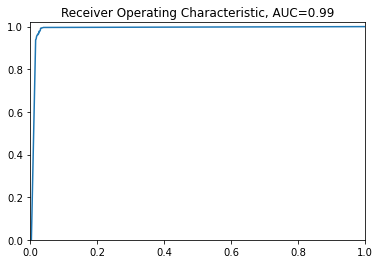

In [17]:
bayes.get_AUC(plot=True)

## Manual test 

In [963]:
emails_test=['''ISGD-7 WASHINGTON D.C.7th INTERNATIONAL SYMPOSIUM ONGRAPHENE DEVICES, ISGD-7 25-28 JULY 2022  https://www.isgd7.comISGD-7 FLYER  VENUE:Holiday Inn Washington Capitol – National Mall550 C Street SW | Washington, DC 20024  After having been postponed for 2 years, ISGD-7 is finally happening! The Symposium on Graphene Devices (ISGD-7) is the main meeting addressing advanced graphene applications, offering a unique forum to review the current status, the latest developments, future prospects and related fundamental studies, covering both state-of-the-art experimental and theoretical discoveries. Opening Plenary Lecture by:‘Electronic and Optoelectronic Devices in Van Der Waals Heterostructures’Prof. Philip KimHarvard University, USA Topics:·       Graphene Electronics, Spintronics, Sensors, Terahertz Devices, Photonics and Energy Applications·       Graphene Nanochemistry and Functionalization, Bioapplications·       Graphene Growth: Epitaxial, CVD, Mechanical and Chemical Exfoliation,  and Substrate Transfer·       Electronic, Structural, Optical, Mechanical and Transport Properties of Graphene·       2D Materials·       Theoretical Investigation and Modelling of Graphene and 2D Material  Devices  Looking forward to welcoming you in Washington DC, Prof. Joshua Caldwell (chair)Vanderbilt University, USA Prof. Tony Low (co-chair)University of Minnesota, USA   IMPORTANT DATE:Abstract submission is OPEN!until 10 April, 2022 ……………. For any assistance, please contactyour ISGD7 Team:contact@isgd7.com''',
'''Dear all,    It's a beautiful spring day. I'll see you in front of Atlantic, 5pm!''',
'''Sounds good. Talk to you then. I will send a meeting invite shortly.''',
'''Want a chance to earn $500? Here’s a special opportunity from IMLeagues for our community!
We are sharing a survey on behalf of an electronics partner who is hoping to get students' perspectives on its product categories.
As a thank you for your survey input, one student will be randomly selected from a pool of respondents from just 20 campuses to receive a $500 Visa Gift Card on Monday, 2/28. If you are selected as a winner, we will contact you at the email address you provide at the end of the survey.
Our short survey takes about 7-10 minutes. Click below to share your thoughts!
''']

In [962]:
emails_test_clean=clean_text(emails_test)

In [964]:
bayes.add_test(emails_test_clean,[1,0,0,1])

In [965]:
bayes.get_posterior()

,NonSpam,Spam
0,2.770241e-01,0.722976
1,3.324002e-01,0.667600
2,9.556877e-01,0.044312
3,5.391195e-07,0.999999


In [966]:
bayes.get_confusion_matrix()

(Prediction  Negative  Positive
 Actual                        
 Negative           1         1
 Positive           0         2,
 0.6666666666666666,
 1.0,
 0.8)

# Cross validation to fine-tune parameters

In [967]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k)

In [968]:
max_features_option=[500,1000,2000,4000,None]
smoothing_factor_option=[.5,1,2,4]

In [969]:
from itertools import product

In [971]:
i=0
for train_index,test_index in k_fold.split(emails_clean,labels):
    print(i)
    i+=1
    auc_dict=defaultdict(list)
    # bayes=Bayes(np.array(emails_clean)[train_index],np.array(labels)[train_index],np.array(emails_clean)[test_index],np.array(labels)[test_index])
    bayes=Bayes([emails_clean[i] for i in train_index],[labels[i] for i in train_index],[emails_clean[i] for i in test_index],[labels[i] for i in test_index])
    for max_features,smoothing in product(max_features_option,smoothing_factor_option):
        bayes.countvectorizer(max_features=max_features)
        bayes.get_label_index()
        bayes.get_prior()
        bayes.get_likelihood(smoothing=smoothing)
        bayes.get_posterior()
        auc_dict[(max_features,smoothing)].append(bayes.get_AUC(plot=False))

0
1
2
3
4


In [972]:
auc_mean_dict={}
for max_features,smoothing in product(max_features_option,smoothing_factor_option):
    auc_mean_dict[(max_features,smoothing)]=np.mean(auc_dict[(max_features,smoothing)])

In [973]:
keys=sorted(auc_mean_dict,key=lambda x:auc_mean_dict[x],reverse=True)
[(key,auc_mean_dict[key]) for key in keys]

[((None, 4), 0.9807359889100743),
 ((None, 2), 0.9795370649538956),
 ((None, 1), 0.9791384063477011),
 ((None, 0.5), 0.9786374869687918),
 ((2000, 0.5), 0.9770761180965838),
 ((2000, 1), 0.9770226115993286),
 ((2000, 2), 0.9768096856616492),
 ((2000, 4), 0.976422643597622),
 ((1000, 0.5), 0.9692615293740989),
 ((1000, 1), 0.9691421078004554),
 ((1000, 2), 0.9678014972314787),
 ((1000, 4), 0.9676777634565761),
 ((4000, 0.5), 0.9633103396201707),
 ((4000, 1), 0.9631399196663307),
 ((4000, 4), 0.9627630420766998),
 ((4000, 2), 0.9626922427723548),
 ((500, 0.5), 0.961807713489604),
 ((500, 1), 0.9612363028207253),
 ((500, 2), 0.9606137177634354),
 ((500, 4), 0.9598105922799629)]

In [979]:
max_features_option=[None,]
smoothing_factor_option=np.arange(4,20)

In [980]:
i=0
for train_index,test_index in k_fold.split(emails_clean,labels):
    print(i)
    i+=1
    auc_dict=defaultdict(list)
    bayes=Bayes([emails_clean[i] for i in train_index],[labels[i] for i in train_index],[emails_clean[i] for i in test_index],[labels[i] for i in test_index])
    for max_features,smoothing in product(max_features_option,smoothing_factor_option):
        bayes.countvectorizer(max_features=max_features)
        bayes.get_label_index()
        bayes.get_prior()
        bayes.get_likelihood(smoothing=smoothing)
        bayes.get_posterior()
        auc_dict[(max_features,smoothing)].append(bayes.get_AUC(plot=False))
    

0
1
2


/tmp/ipykernel_20472/323215144.py:154: RuntimeWarning: invalid value encountered in long_scalars
  precision=TP/(TP+FP)


3
4


In [981]:
auc_mean_dict={}
for max_features,smoothing in product(max_features_option,smoothing_factor_option):
    auc_mean_dict[(max_features,smoothing)]=np.mean(auc_dict[(max_features,smoothing)])

In [982]:
keys=sorted(auc_mean_dict,key=lambda x:auc_mean_dict[x],reverse=True)
[(key,auc_mean_dict[key]) for key in keys]

[((None, 13), 0.9879357369367143),
 ((None, 12), 0.9878041267942059),
 ((None, 14), 0.9877251871099326),
 ((None, 7), 0.9877166067094684),
 ((None, 15), 0.9877100504034725),
 ((None, 11), 0.9876534197604072),
 ((None, 10), 0.9876392510991274),
 ((None, 8), 0.9876203742181056),
 ((None, 9), 0.9875746120822951),
 ((None, 16), 0.9875494429075993),
 ((None, 17), 0.9875305660265775),
 ((None, 18), 0.9870807330319721),
 ((None, 19), 0.9869213135915479),
 ((None, 6), 0.9812136752046491),
 ((None, 5), 0.9808823397405604),
 ((None, 4), 0.9807359889100743)]

Text(0, 0.5, 'AUC')

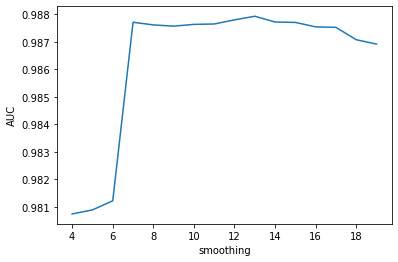

In [986]:
fig,ax=plt.subplots()
ax.plot(smoothing_factor_option,[auc_mean_dict[(None,i)] for i in smoothing_factor_option])
ax.set_xlabel('smoothing')
ax.set_ylabel('AUC')